In [69]:
import torch
from torch import nn as nn # for NN
from torch.utils.data import Dataset # class to create dataset class
from torch import optim # Optimizer
from torch.nn import functional as F # activation functions
import matplotlib.pyplot as plt # to plot a graph
import pandas as pd # py data analysis

In [70]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [71]:
class DataSet(Dataset):
    
    def __init__(self,path):
        self.dataset = torch.tensor(pd.read_csv(path).values)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self,i):
        return self.dataset[i,:-1], self.dataset[i,-1]
    

In [72]:
df=pd.read_csv(r'heart.csv')

In [94]:
class Net(nn.Module):
    def __init__(self, n_features):
        super().__init__()

        self.n_features = n_features # 13

        # fully connected
        self.fc1 = nn.Linear(self.n_features,16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.sigmoid(self.fc3(out))

        return out

In [95]:
def training_loop(n_epoch,optimizer,model,loss_fn,train_loader,test_loader,print_plot):
    
    train_accuracy=torch.zeros(n_epoch)
    test_accuracy=torch.zeros(n_epoch)
    
    for epoch in range(n_epoch):
        for example,label in train_loader:
            example=example.to(DEVICE)
            label = label.to(DEVICE)
            label=label.unsqueeze(1)
            output=model(example.float())
            loss=loss_fn(output,label.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        with torch.no_grad():

            for loader, accuracy in [(train_loader, train_accuracy),(test_loader, test_accuracy)]:
                correct = 0
                total = 0

                for examples, labels in loader:
                    examples = examples.to(device=DEVICE)
                    labels = labels.to(device=DEVICE).view(-1, 1)

                    outputs = model(examples.float())
                    predicted = torch.round(outputs)

                    total += labels.shape[0]
                    correct += (predicted == labels).sum()

                accuracy[epoch] = correct / total

        if (epoch+1) % 10 ==0:
            print(f'Epoch {epoch+1})', 
                  f'Train Accuracy: {train_accuracy[epoch]}',
                  f'Test Accuracy: {test_accuracy[epoch]}')
            
    if print_plot:
        epoch = range(n_epoch)

        #Ploting both curves, train and val 
        plt.plot(epoch, train_accuracy, 'g', label='Training accuracy')
        plt.plot(epoch, test_accuracy, 'b', label='Test accuracy')
        plt.title('Training and Test loss')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show() 
        

In [96]:
data = DataSet(r'heart.csv')
n_sample = len(data)
n_test = int(0.2*n_sample)
train_set,test_set=torch.utils.data.random_split(data,[n_sample-n_test,n_test])
train_loader = torch.utils.data.DataLoader(train_set,batch_size=len(train_set),shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=len(test_set),shuffle=True)


C:\Users\NICU\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 10) Train Accuracy: 0.6255143880844116 Test Accuracy: 0.4333333373069763
Epoch 20) Train Accuracy: 0.6419752836227417 Test Accuracy: 0.4333333373069763
Epoch 30) Train Accuracy: 0.6790123581886292 Test Accuracy: 0.46666666865348816
Epoch 40) Train Accuracy: 0.6913580298423767 Test Accuracy: 0.6333333253860474
Epoch 50) Train Accuracy: 0.7242798209190369 Test Accuracy: 0.7166666388511658
Epoch 60) Train Accuracy: 0.7242798209190369 Test Accuracy: 0.7166666388511658
Epoch 70) Train Accuracy: 0.7530864477157593 Test Accuracy: 0.7333333492279053
Epoch 80) Train Accuracy: 0.748971164226532 Test Accuracy: 0.7333333492279053
Epoch 90) Train Accuracy: 0.7613168954849243 Test Accuracy: 0.7333333492279053
Epoch 100) Train Accuracy: 0.7736625671386719 Test Accuracy: 0.75
Epoch 110) Train Accuracy: 0.806584358215332 Test Accuracy: 0.7666666507720947
Epoch 120) Train Accuracy: 0.8148148059844971 Test Accuracy: 0.7833333611488342
Epoch 130) Train Accuracy: 0.8148148059844971 Test Accuracy: 0.8

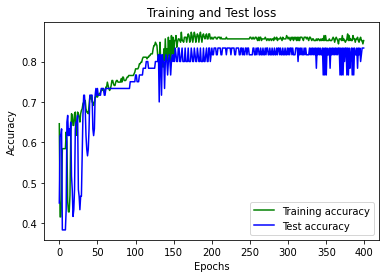

In [102]:
learning_rate=0.01

model=Net(len(data[0][0])).to(DEVICE)

optimizer = optim.Adam(model.parameters(),lr=learning_rate)

loss_fn=nn.BCELoss()

training_loop(
n_epoch=400,
optimizer=optimizer,
model=model,
loss_fn=loss_fn,
train_loader=train_loader,
test_loader=test_loader,
print_plot=True)
